--- 

# <center> Project ML for Time Series 
## <center> Feature Selection: A Data Perspective
## <center> Regression Problem
<center>Work done by : 

##### <center> Ali HAIDAR email : ali.haidar@polytechnique.edu
##### <center> Maya AWADA  email : maya.awada24@gmail.com 

---

This notebook is divided to several parts:

1- Prepare the data and clean it.

2- Try the feature selection models on the data and Compare them to the feature selected by brute force.

3- Do data augmentation by creating new features.

4 - Try the feature selection models on the augmented data. 

# Preparing the data


We used the data provided by QRT for a challenge on ENS data challenge platform. The aim is to model the electricity price from weather, energy (commodities) and commercial data for two European countries - France and Germany. 

The link of the challenge : https://challengedata.ens.fr/challenges/97

In [1]:
import numpy as np
import pandas as pd
from scipy.stats import spearmanr
from sklearn.linear_model import LinearRegression, Lasso, LassoCV
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn import metrics
from sklearn.model_selection import GridSearchCV, train_test_split, KFold, cross_val_score
from operator import itemgetter
from itertools import chain, combinations
from tqdm import tqdm
import collections
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
import lightgbm as lgbm
from tabulate import tabulate

import utils
import evaluation
import CustomLassoModel
import features_selection
import NN

import matplotlib.pyplot as plt
import seaborn as sns

sns.set()
np.random.seed(42) # For reproducibility purposes
pd.set_option('display.max_columns', None) # Display all columns when showing a pandas dataframe

In [2]:
path = 'regression_data/'
X_train = pd.read_csv( path + 'X_train.csv')
Y_train = pd.read_csv(path + 'Y_train.csv')
X_test = pd.read_csv(path + 'X_test.csv')

## Description of the data

- ID: Unique row identifier, associated with a day (DAY_ID) and a country (COUNTRY),
- DAY_ID: Day identifier - dates have been anonymized, but all data corresponding to a specific day is consistent,
- COUNTRY: Country identifier - DE = Germany, FR = France, 

and then contains daily commodity price variations:

- GAS_RET: European gas,
- COAL_RET: European coal,
- CARBON_RET: Carbon emissions futures,

weather measures (daily, in the country x):

- x_TEMP: Temperature,
- x_RAIN: Rainfall,
- x_WIND: Wind,

energy production measures (daily, in the country x),

- x_GAS: Natural gas,
- x_COAL: Hard coal,
- x_HYDRO: Hydro reservoir,
- x_NUCLEAR: Daily nuclear production,
- x_SOLAR: Photovoltaic,
- x_WINDPOW: Wind power,
- x_LIGNITE: Lignite,

and electricity use metrics (daily, in the country x),

- x_CONSUMPTON: Total electricity consumption,
- x_RESIDUAL_LOAD: Electricity consumption after using all renewable energies,
- x_NET_IMPORT: Imported electricity from Europe,
- x_NET_EXPORT: Exported electricity to Europe,
- DE_FR_EXCHANGE: Total daily electricity exchange between Germany and France,
- FR_DE_EXCHANGE: Total daily electricity exchange between France and Germany.

Output data sets are composed of two columns:

- ID: Unique row identifier - corresponding to the input identifiers,
- TARGET: Daily price variation for futures of 24H electricity baseload.

In [3]:
all_data = pd.merge(X_train, Y_train, on=['ID'])
all_data['train'] = 1
all_data = pd.concat([all_data,X_test])
all_data['TARGET'] = all_data['TARGET'].fillna(0)
all_data['train'] = all_data['train'].fillna(0)
all_data['train']  = all_data['train'].astype(int) 
all_data.describe()

,ID,DAY_ID,DE_CONSUMPTION,FR_CONSUMPTION,DE_FR_EXCHANGE,FR_DE_EXCHANGE,DE_NET_EXPORT,FR_NET_EXPORT,DE_NET_IMPORT,FR_NET_IMPORT,...,FR_RAIN,DE_WIND,FR_WIND,DE_TEMP,FR_TEMP,GAS_RET,COAL_RET,CARBON_RET,TARGET,train
count,2148.00000,2148.000000,2148.000000,2148.000000,2114.000000,2114.000000,1977.000000,2054.000000,1977.000000,2054.000000,...,2014.000000,2014.000000,2014.000000,2014.000000,2014.000000,2148.000000,2148.000000,2148.000000,2148.000000,2148.000000
mean,1073.50000,604.309125,0.429817,-0.003449,-0.114830,0.114830,-0.245501,-0.088621,0.245501,0.088621,...,0.008455,0.103704,0.109674,-0.005285,-0.009413,0.060070,0.072950,0.070170,0.062552,0.695531
std,620.21851,349.088770,0.714875,0.939784,0.950303,0.950303,0.952955,1.054911,0.952955,1.054911,...,1.035476,1.041639,1.031072,0.985023,1.010942,1.091539,1.023083,1.092801,0.863731,0.460289
min,0.00000,0.000000,-7.433311,-4.591011,-2.856874,-2.634831,-2.464849,-2.825331,-2.279619,-1.951516,...,-2.046479,-1.880419,-1.895319,-4.549638,-5.787097,-5.349463,-5.706442,-4.281790,-6.519268,0.000000
25%,536.75000,302.000000,-0.017582,-0.717684,-0.830239,-0.635085,-0.973313,-0.859648,-0.480707,-0.790383,...,-0.498004,-0.650091,-0.665751,-0.677700,-0.699078,-0.601147,-0.458038,-0.527112,-0.108862,0.000000
50%,1073.50000,604.000000,0.360249,-0.388808,-0.116238,0.116238,-0.293294,0.073083,0.293294,-0.073083,...,-0.243203,-0.240327,-0.222704,-0.053459,-0.049865,0.034189,0.078560,0.039072,0.000000,1.000000
75%,1610.25000,906.250000,0.960286,0.731576,0.635085,0.830239,0.480707,0.790383,0.973313,0.859648,...,0.137025,0.632464,0.744274,0.653668,0.683419,0.676415,0.683850,0.598996,0.108285,1.000000
max,2147.00000,1215.000000,2.033851,3.300640,2.634831,2.856874,2.279619,1.951516,2.464849,2.825331,...,11.489768,7.149098,4.965028,3.113181,2.817239,5.674778,3.868088,5.471818,7.786578,1.000000


## Cleaning the data 

In [4]:
# number of NaN data
all_data.isnull().sum() 

ID                    0
DAY_ID                0
COUNTRY               0
DE_CONSUMPTION        0
FR_CONSUMPTION        0
DE_FR_EXCHANGE       34
FR_DE_EXCHANGE       34
DE_NET_EXPORT       171
FR_NET_EXPORT        94
DE_NET_IMPORT       171
FR_NET_IMPORT        94
DE_GAS                0
FR_GAS                0
DE_COAL               0
FR_COAL               0
DE_HYDRO              0
FR_HYDRO              0
DE_NUCLEAR            0
FR_NUCLEAR            0
DE_SOLAR              0
FR_SOLAR              0
DE_WINDPOW            0
FR_WINDPOW            0
DE_LIGNITE            0
DE_RESIDUAL_LOAD      0
FR_RESIDUAL_LOAD      0
DE_RAIN             134
FR_RAIN             134
DE_WIND             134
FR_WIND             134
DE_TEMP             134
FR_TEMP             134
GAS_RET               0
COAL_RET              0
CARBON_RET            0
TARGET                0
train                 0
dtype: int64

It is worth to mention that :
- DE_FR_EXCHANGE = - FR_DE_EXCHANGE
- DE_NET_EXPORT  = - DE_NET_IMPORT
- FR_NET_EXPORT = - FR_NET_IMPORT

Therefore, we keep only one column of each

To clean the data, we replaced the NaN values in DE_FR_EXCHANGE with its mean.

After that, we build a regression model to predict the missing value of DE_NET_EXPORT and FR_NET_EXPORT from DE_FR_EXCHANGE.

In [5]:
all_data_clean = utils.clean_data(all_data)

Model_regression DE_NET_EXPORT score : 0.49328444244850245
Model_regression FR_NET_EXPORT score : 0.4424460230408356


## Remove The Outliers 

In [6]:
cols = ['DE_CONSUMPTION', 'FR_CONSUMPTION',
       'FR_DE_EXCHANGE', 'DE_NET_EXPORT', 'FR_NET_EXPORT', 'DE_GAS', 'FR_GAS',
       'DE_COAL', 'FR_COAL', 'DE_HYDRO', 'FR_HYDRO', 'DE_NUCLEAR',
       'FR_NUCLEAR', 'DE_SOLAR', 'FR_SOLAR', 'DE_WINDPOW', 'FR_WINDPOW',
       'DE_LIGNITE', 'DE_RESIDUAL_LOAD', 'FR_RESIDUAL_LOAD', 'DE_RAIN',
       'FR_RAIN', 'DE_WIND', 'FR_WIND', 'DE_TEMP', 'FR_TEMP', 'GAS_RET',
       'COAL_RET', 'CARBON_RET', 'DE_CONSUMPTION_RENEWABLE',
       'FR_CONSUMPTION_RENEWABLE']

### Before and After Removing the Outliers

In [7]:
all_data_clean_before_check = all_data_clean.copy()
all_data_clean_before_check['train'] = all_data_clean_before_check.apply(lambda x: 'train' if(x['train']==1) else 'test',axis=1)


#Remove the outliers in the training data
all_data_clean_after = all_data_clean.copy()
all_data_clean_after = utils.remove_outliers(all_data_clean_after, cols, threshold=2.5) 

#Replace the outliers in the test data
all_data_clean_after = utils.replace_outliers(all_data_clean_after, cols, threshold=2.5)

all_data_clean_after_check = all_data_clean_after.copy()
all_data_clean_after_check['train'] = all_data_clean_after.apply(lambda x: 'train' if(x['train']==1) else 'test',axis=1)

In [8]:
'''
for i, c in enumerate(cols):
    plt.figure(figsize=(20, 10))
    plt.subplot(1,2,1)
    sns.boxplot(data=all_data_clean_before_check, x=c,  y = 'train',   orient='h')
    plt.title("Before")
    plt.subplot(1,2,2)
    sns.boxplot(data=all_data_clean_after_check, x=c,  y = 'train',   orient='h')
    plt.title("After")
    plt.show()
'''

'\nfor i, c in enumerate(cols):\n    plt.figure(figsize=(20, 10))\n    plt.subplot(1,2,1)\n    sns.boxplot(data=all_data_clean_before_check, x=c,  y = \'train\',   orient=\'h\')\n    plt.title("Before")\n    plt.subplot(1,2,2)\n    sns.boxplot(data=all_data_clean_after_check, x=c,  y = \'train\',   orient=\'h\')\n    plt.title("After")\n    plt.show()\n'

## The Model :

We will use linear model as base model because the number of training data is not big and using a complexe model will lead to an overfit. 

You can see our modified version of linear model in model.py


## Scoring :

We will measure the accuracy of the model by the spearman correlation between the predicted values and the real values.

The formula for the Spearman rank correlation coefficient when there are no tied ranks is:

$$\rho = 1 - \frac{6\sum d_i^2}{n(n^2-1)}$$

where $d_i$ is the difference of rank.

## Evaluation 

To evaluate the model, we will divide the training set between 70% of training and 30% of testing.

We will do this step for number_of_state (~100) times and calculate the mean of the score over all these test data.

This is close to cross validation, and it will help us to get an estimation of the generalized error.

Also, we will provide the score obtained by these method on the test set of the challenge.

You can find this function in model.py

In [9]:
# Get the original split
X_train, y_train, X_test, id_test = utils.split(all_data_clean)
X_test.index = id_test

# center the country column
X_train['COUNTRY'] = 2*X_train['COUNTRY'] - 1 
X_test['COUNTRY'] = 2*X_test['COUNTRY'] - 1 

# Scale the data to be between zero and one 
X = pd.concat([X_train,X_test])
scaler = StandardScaler()
scaler.fit(X)
cols = X.columns

X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

X_train_scaled[cols] = scaler.transform(X_train[cols])
X_test_scaled[cols] = scaler.transform(X_test[cols])

stratify = X_train['COUNTRY']

X_train = X_train_scaled
X_test = X_test_scaled


# Features Selection

### Brute Force Features Selection

We have 32 columns in X_train, therefore doing brute force is feasible.

In [10]:
benchmark = {} # A dictionary contains the name of the method and the scores and the features of these method

In [11]:
'''
cols = X_train.columns[:-1]

best_score = {} # A dict contains the best scores for each number of features

for n_features in tqdm(range(2,len(cols))):
    for comb in combinations(cols,n_features):
        comb = list(comb)
        if(len(comb) == 0):
            continue
        comb.append('COUNTRY_split')
        score = model.evaluate_model_by_country(X_train[comb], y_train, LinearRegression(), stratify = X_train['COUNTRY_split']  ,  test_size=0.33, state = 5)
        if(n_features not in best_score):
            best_score[n_features] = list(score) + comb[:-1]
        if(best_score[n_features][1] < score[1]):
            best_score[n_features] = list(score) + comb[:-1]
            
best_test_score = []
best_test_score_FR = []
best_test_score_DE = []
for n_features in tqdm(range(2,len(cols))):
    best_test_score.append(best_score[n_features][1])
    best_test_score_FR.append(best_score[n_features][2])
    best_test_score_DE.append(best_score[n_features][3])
    
plt.plot(range(2,len(cols)), best_test_score,label = 'test_score')
plt.plot(range(2,len(cols)), best_test_score,label = 'test_FR_score')
plt.plot(range(2,len(cols)), best_test_score,label = 'test_DE_score')
plt.legend()
plt.xlabel('number of features')
plt.ylabel('Spearman score')
plt.plot()            
'''

"\ncols = X_train.columns[:-1]\n\nbest_score = {} # A dict contains the best scores for each number of features\n\nfor n_features in tqdm(range(2,len(cols))):\n    for comb in combinations(cols,n_features):\n        comb = list(comb)\n        if(len(comb) == 0):\n            continue\n        comb.append('COUNTRY_split')\n        score = model.evaluate_model_by_country(X_train[comb], y_train, LinearRegression(), stratify = X_train['COUNTRY_split']  ,  test_size=0.33, state = 5)\n        if(n_features not in best_score):\n            best_score[n_features] = list(score) + comb[:-1]\n        if(best_score[n_features][1] < score[1]):\n            best_score[n_features] = list(score) + comb[:-1]\n            \nbest_test_score = []\nbest_test_score_FR = []\nbest_test_score_DE = []\nfor n_features in tqdm(range(2,len(cols))):\n    best_test_score.append(best_score[n_features][1])\n    best_test_score_FR.append(best_score[n_features][2])\n    best_test_score_DE.append(best_score[n_features][3

### Lasso Features Selection

100%|██████████| 20/20 [00:03<00:00,  5.97it/s]


The best regularization =  0.015
The best_score =  0.22551805218429855
The best_features =  ['COUNTRY', 'DE_CONSUMPTION', 'FR_DE_EXCHANGE', 'DE_NET_EXPORT', 'FR_COAL', 'DE_HYDRO', 'FR_HYDRO', 'DE_NUCLEAR', 'FR_NUCLEAR', 'DE_SOLAR', 'FR_WINDPOW', 'DE_LIGNITE', 'FR_RAIN', 'FR_WIND', 'GAS_RET', 'COAL_RET', 'DE_CONSUMPTION_RENEWABLE']


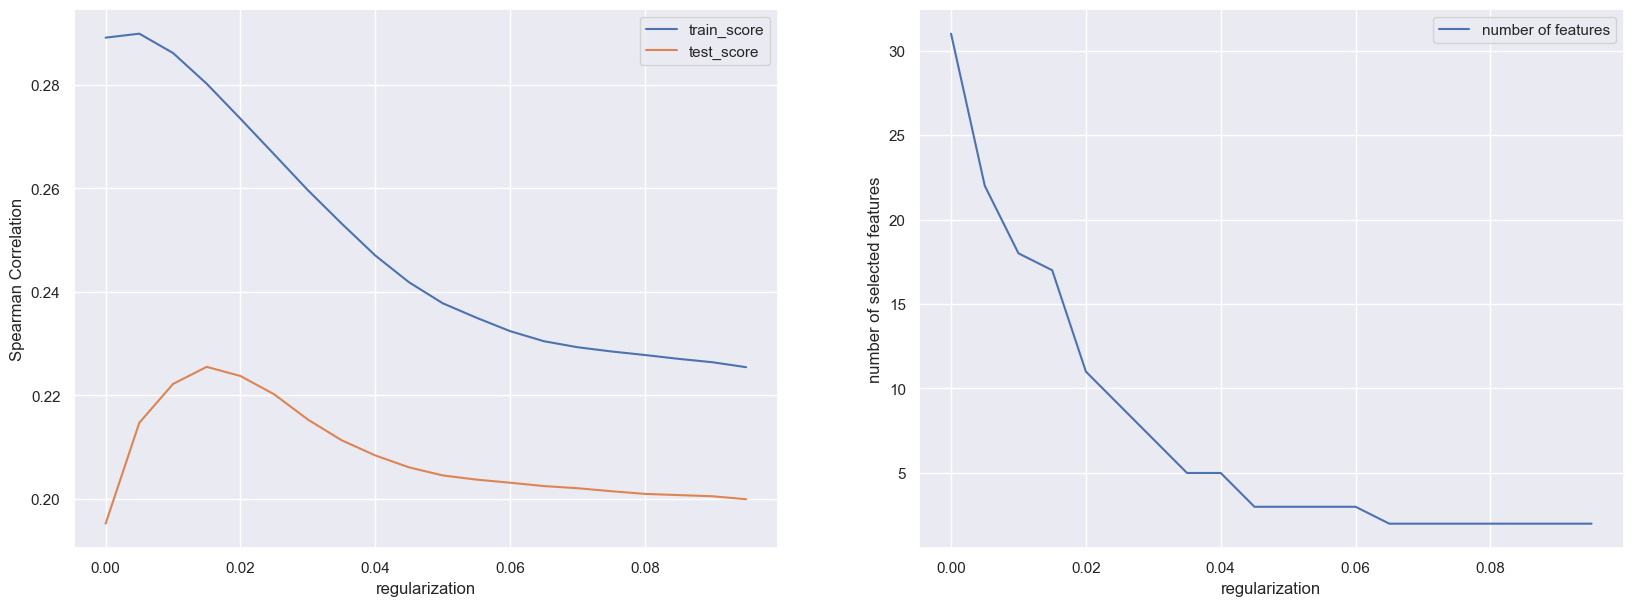

In [12]:
model = Lasso#CustomLassoModel.CustomLassoModel

regularization, best_score, best_features = features_selection.lasso_feature_selection(X_train, y_train, model, stratify, number_of_states = 20)

benchmark['lasso'] = dict({'lasso': dict({'test_score':best_score,  'features':best_features})})
print("The best regularization = ", regularization)
print("The best_score = ", best_score)

print("The best_features = ", best_features)


### Models to use for benchmark

In [13]:
linear_model =  LinearRegression()
random_forest = lgbm.LGBMRegressor(boosting_type="rf",
                         num_leaves=165,
                         colsample_bytree=.5,
                         n_estimators=400,
                         min_child_weight=5,
                         min_child_samples=10,
                         subsample=.632, # Standard RF bagging fraction
                         subsample_freq=1,
                         min_split_gain=0,
                         n_jobs=-1)
neural_network = NN.Net()
models = [ linear_model]#,linear_model, neural_network]

### Run the model without features selection

In [14]:
for model in models:
    best_score = evaluation.evaluate_model(X_train, y_train, model, stratify ,  test_size=0.33, number_of_states = 20)[1]
    best_features = X_train.columns
    benchmark[type(model).__name__ ] = dict({'w/o FS': dict({'test_score':best_score,  'features':best_features})})

### Sequential Feature Selection

In [15]:

best_score, best_features = features_selection.sequential_features_selection(X_train, np.array(y_train), models[:1], stratify, number_of_states = 20, test_size = 0.3, max_features = 32)
for i in range(len(models[:1])):
    model = models[i]
    benchmark[type(model).__name__ ]['sfs'] = {'test_score':best_score[i], 'features':best_features[i]}

    print("The best_score of " + type(model).__name__ + " = ", best_score[i])
    print("The best_features of " + type(model).__name__  +" = ", best_features[i])

LinearRegression


 33%|███▎      | 10/30 [01:40<03:21, 10.07s/it]


KeyboardInterrupt: 

### Greedy Sequential Feature Selection

LinearRegression


100%|██████████| 32/32 [00:02<00:00, 13.61it/s]


The best_score of LinearRegression =  0.23598366251054412
The best_features of LinearRegression =  ['COUNTRY', 'DE_CONSUMPTION', 'FR_CONSUMPTION', 'DE_NET_EXPORT', 'DE_GAS', 'DE_HYDRO', 'DE_NUCLEAR', 'FR_NUCLEAR']


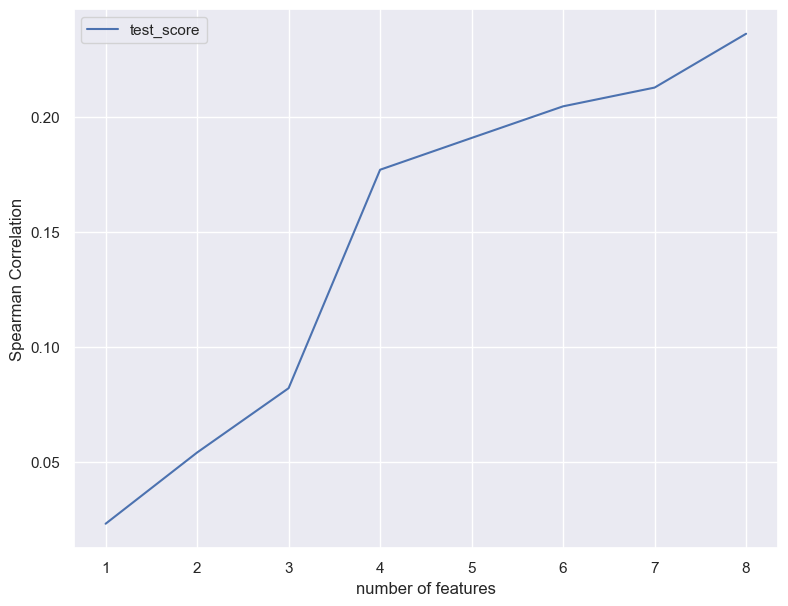

In [16]:

best_score, best_features = features_selection.greedy_features_selection(X_train, np.array(y_train), models, stratify, threshold = 0.005, number_of_states = 20, test_size = 0.3)
for i in range(len(models)):
    model = models[i]
    benchmark[type(model).__name__ ]['gsfs']  = {'test_score':best_score[i], 'features':best_features[i]}

    print("The best_score of " + type(model).__name__ + " = ", best_score[i])
    print("The best_features of " + type(model).__name__  +" = ", best_features[i])


### Feature Selection Using Laplace Score

#### Laplace Tuning

100%|██████████| 10/10 [00:38<00:00,  3.87s/it]


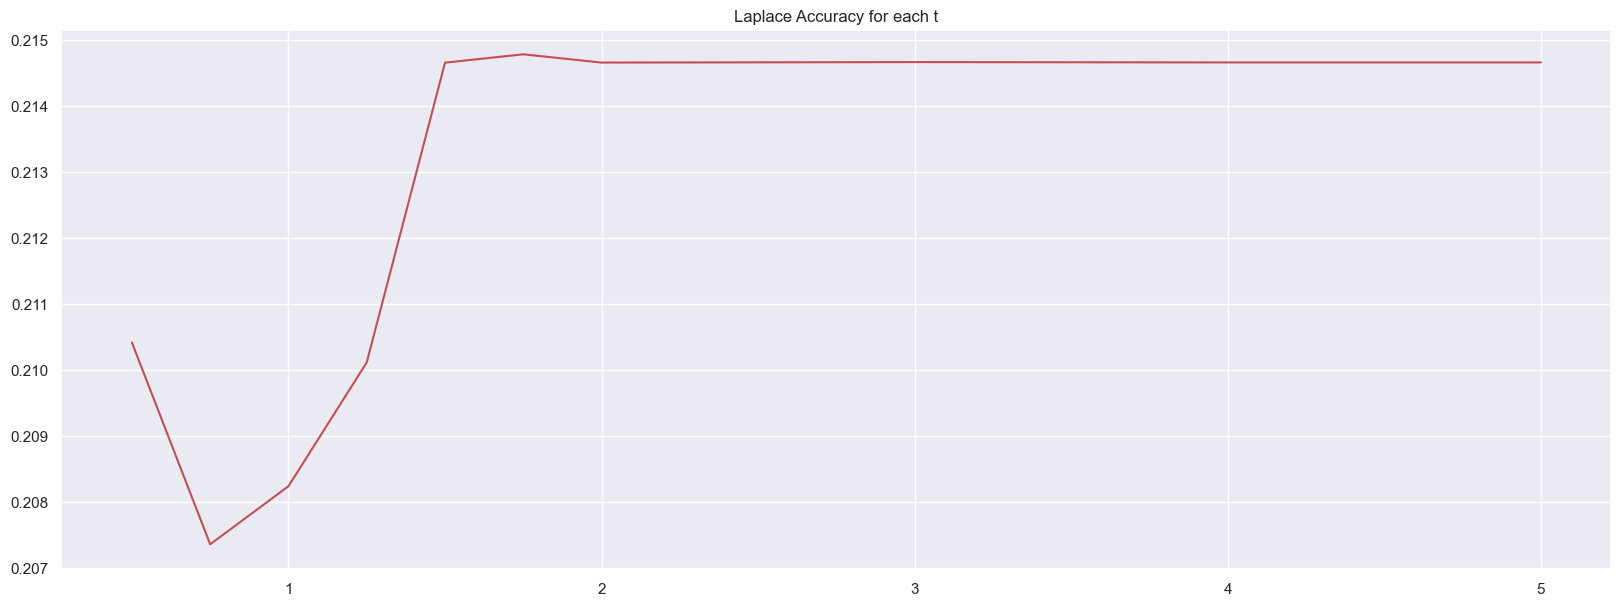

In [ ]:
laplace_var = features_selection.tune_laplace_features_selection(X_train, y_train, X_test, models[:1], stratify, var = [0.5, 0.75, 1, 1.25, 1.5, 1.75, 2, 3, 4, 5], number_of_states = 20, test_size = 0.3, max_features = 32)

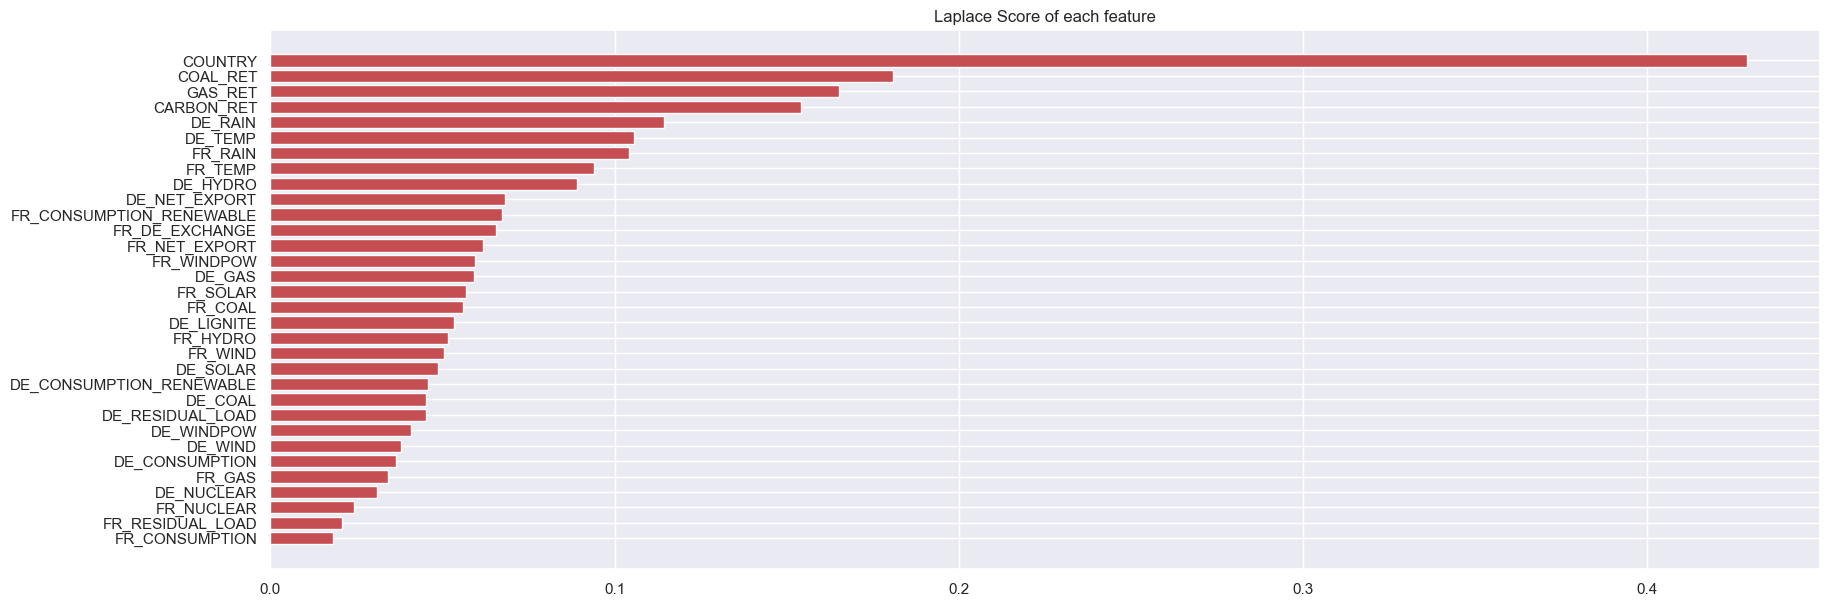

LinearRegression


100%|██████████| 30/30 [00:03<00:00,  8.93it/s]


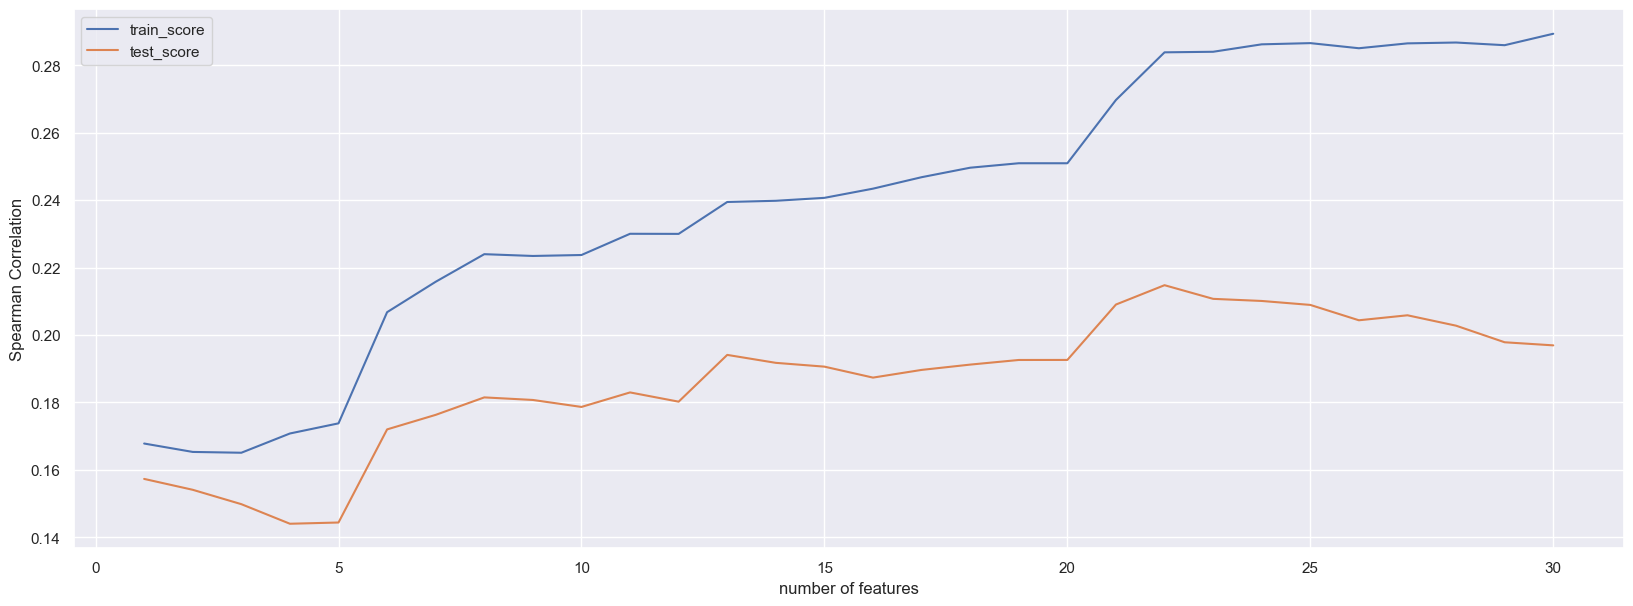

The best_score of LinearRegression =  0.21478845679416847
The best_features of LinearRegression =  ['FR_CONSUMPTION', 'FR_RESIDUAL_LOAD', 'FR_NUCLEAR', 'DE_NUCLEAR', 'FR_GAS', 'DE_CONSUMPTION', 'DE_WIND', 'DE_WINDPOW', 'DE_RESIDUAL_LOAD', 'DE_COAL', 'DE_CONSUMPTION_RENEWABLE', 'DE_SOLAR', 'FR_WIND', 'FR_HYDRO', 'DE_LIGNITE', 'FR_COAL', 'FR_SOLAR', 'DE_GAS', 'FR_WINDPOW', 'FR_NET_EXPORT', 'FR_DE_EXCHANGE', 'FR_CONSUMPTION_RENEWABLE', 'DE_NET_EXPORT', 'DE_HYDRO']


In [ ]:

best_score, best_features = features_selection.laplace_features_selection(X_train, y_train, X_test, models, stratify, laplace_var, number_of_states = 20)

for i in range(len(models)):
    model = models[i]
    benchmark[type(model).__name__ ]['Laplace'] = {'test_score':best_score[i], 'features':best_features[i]}
    print("The best_score of " + type(model).__name__ + " = ", best_score[i])
    print("The best_features of " + type(model).__name__  +" = ", best_features[i])

## Features Selection Using Information Theory:

### Minimum Redundancy Maximum Relevance (MRMR)

The score of each new feature :
$$J_{MRMR}(X_k) = I(X_k,Y) - \frac{1}{|S|}\sum_{X_j \in s}I(X_k,x_j)$$

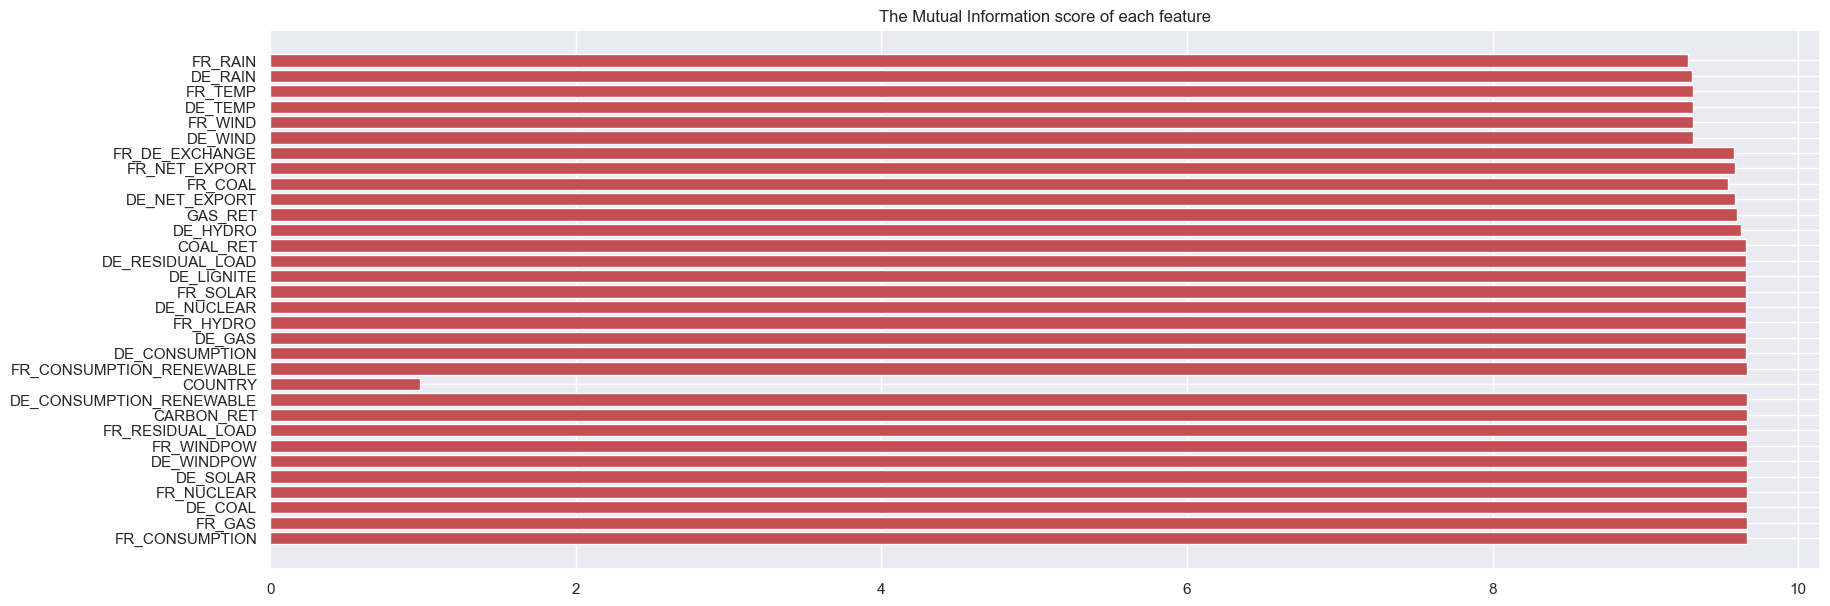

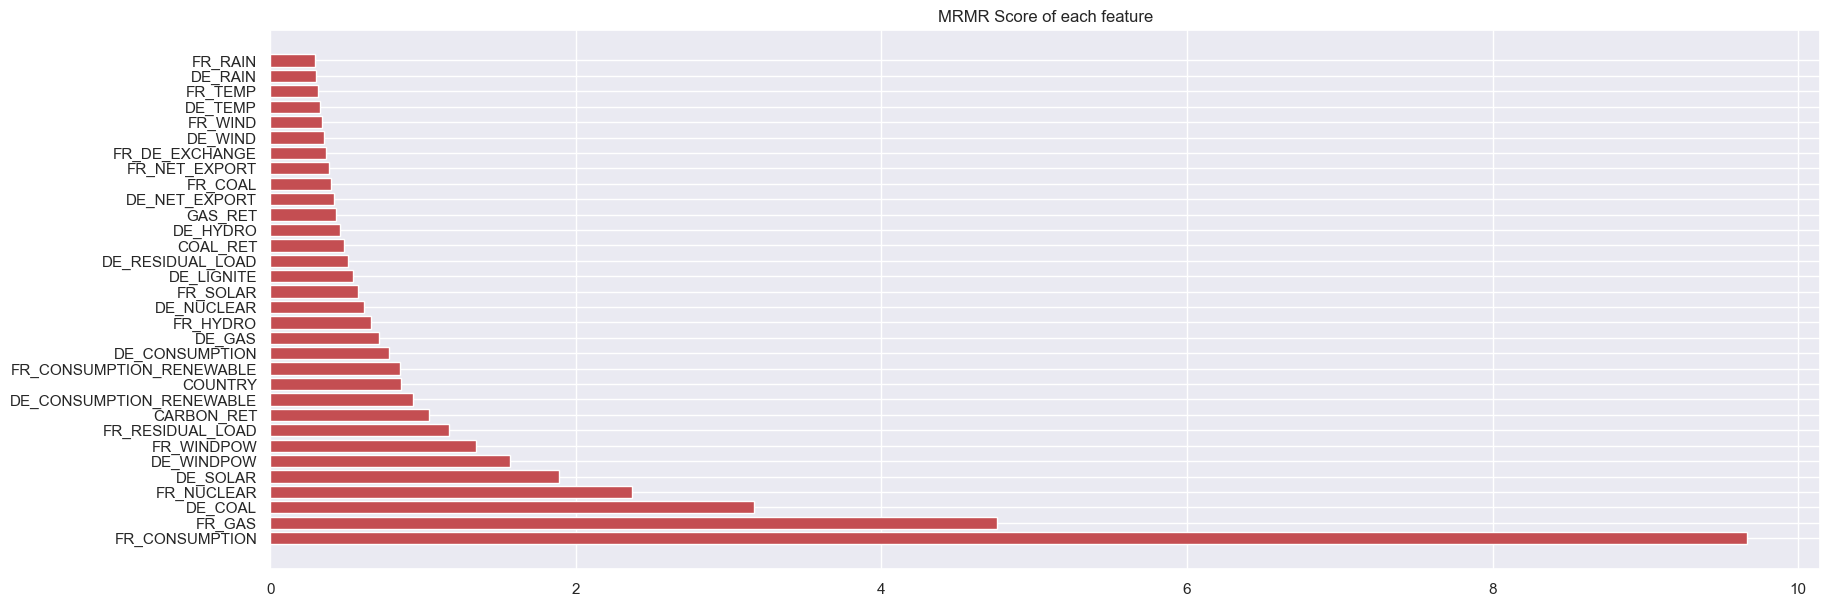

LinearRegression


100%|██████████| 30/30 [00:03<00:00,  8.57it/s]


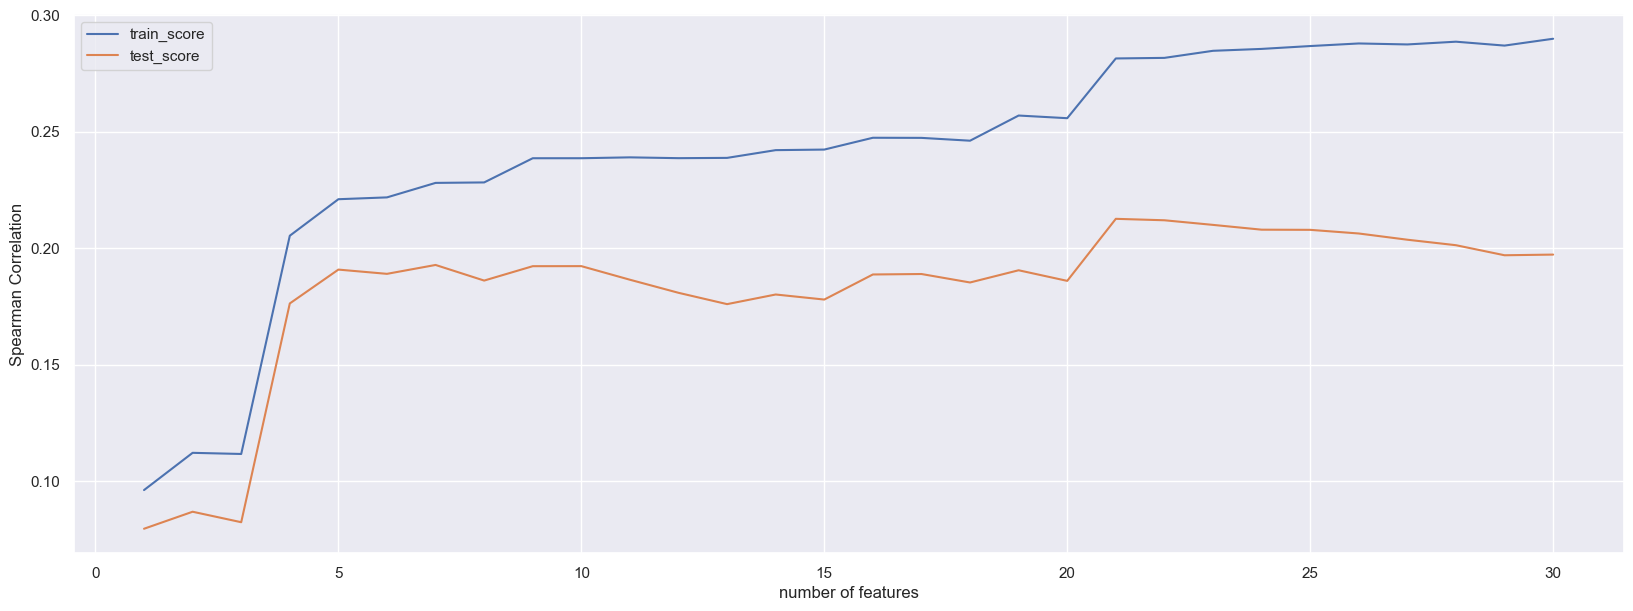

The best_score of LinearRegression =  0.21257770507019574
The best_features of LinearRegression =  ['FR_CONSUMPTION', 'FR_GAS', 'DE_COAL', 'FR_NUCLEAR', 'DE_SOLAR', 'DE_WINDPOW', 'FR_WINDPOW', 'FR_RESIDUAL_LOAD', 'CARBON_RET', 'DE_CONSUMPTION_RENEWABLE', 'COUNTRY', 'FR_CONSUMPTION_RENEWABLE', 'DE_CONSUMPTION', 'DE_GAS', 'FR_HYDRO', 'DE_NUCLEAR', 'FR_SOLAR', 'DE_LIGNITE', 'DE_RESIDUAL_LOAD', 'COAL_RET', 'DE_HYDRO', 'GAS_RET', 'DE_NET_EXPORT']


In [ ]:
best_score, best_features = features_selection.MRMR_features_selection(X_train, y_train, X_test, models, stratify,  number_of_states = 20)

for i in range(len(models)):
    model = models[i]
    benchmark[type(model).__name__ ]['MRMR'] = {'test_score':best_score[i], 'features':best_features[i]}
    print("The best_score of " + type(model).__name__ + " = ", best_score[i])
    print("The best_features of " + type(model).__name__  +" = ", best_features[i])

In [ ]:
results = pd.DataFrame(columns=['model', 'w/o FS', 'lasso', 'Laplace', 'MRMR', 'sfs', 'gsfs'])
cols = ['w/o FS', 'lasso', 'Laplace', 'MRMR', 'sfs', 'gsfs']
for i in benchmark.keys():
    res = [i]
    for z in cols:
        if(z in benchmark[i]):
            res.append(benchmark[i][z]['test_score'])
        else:
            res.append(np.nan)
    results.loc[len(results)] = res

In [ ]:
print(tabulate(results, headers='keys', tablefmt='fancy_grid'))

╒════╤══════════════════╤════════════╤════════════╤════════════╤════════════╤════════════╤════════════╕
│    │ model            │     w/o FS │      lasso │    Laplace │       MRMR │        sfs │       gsfs │
╞════╪══════════════════╪════════════╪════════════╪════════════╪════════════╪════════════╪════════════╡
│  0 │ lasso            │ nan        │   0.225518 │ nan        │ nan        │ nan        │ nan        │
├────┼──────────────────┼────────────┼────────────┼────────────┼────────────┼────────────┼────────────┤
│  1 │ LinearRegression │   0.196874 │ nan        │   0.214788 │   0.212578 │   0.244334 │   0.235984 │
╘════╧══════════════════╧════════════╧════════════╧════════════╧════════════╧════════════╧════════════╛


In [ ]:
freq = dict()
for i in benchmark.keys():
    for j in benchmark[i].keys():
       
        if(j[:2] == 'DA'):
            continue
        
        if(j == 'w/o FS'):
            continue
        
        if(i not in freq):
            freq[i] = dict()
        if(j not in freq[i]):
            freq[i][j] = 0
        freq[i][j] += (len(benchmark[i][j]['features'])/X_train.shape[1])*100


In [ ]:
freq_data = pd.DataFrame(freq).T
freq_data

,lasso,sfs,gsfs,Laplace,MRMR
lasso,53.125,NaN,NaN,NaN,NaN
LinearRegression,NaN,28.125,25.0,75.0,71.875


## Create new features

Let us in this part, create new features and test the methods above

In [ ]:
all_data_clean = utils.add_new_features(all_data_clean)

# Get the original split
X_train, y_train, X_test, id_test = utils.split(all_data_clean)
X_test.index = id_test

# center the country column
X_train['COUNTRY'] = 2*X_train['COUNTRY'] - 1 
X_test['COUNTRY'] = 2*X_test['COUNTRY'] - 1 



poly = PolynomialFeatures(2,include_bias = False)
X_train_augmented  = poly.fit_transform(X_train)
X_test_augmented = poly.transform(X_test)
X_train_augmented = pd.DataFrame(columns=poly.get_feature_names(X_train.columns),data = np.array(X_train_augmented))
X_test_augmented = pd.DataFrame(columns=poly.get_feature_names(X_train.columns),data = np.array(X_test_augmented))



# Scale the data to be between zero and one 
X = pd.concat([X_train_augmented, X_test_augmented])
scaler = StandardScaler()
scaler.fit(X)
cols = X.columns

X_train_scaled = X_train_augmented.copy()
X_test_scaled = X_test_augmented.copy()

X_train_scaled[cols] = scaler.transform(X_train_augmented[cols])
X_test_scaled[cols] = scaler.transform(X_test_augmented[cols])

stratify = X_train['COUNTRY']

X_train = X_train_scaled
X_test = X_test_scaled


### Without Features Selections

In [ ]:
for model in models:
    best_score = evaluation.evaluate_model(X_train, y_train, model, stratify ,  test_size=0.33, number_of_states = 20)[1]
    best_features = X_train.columns
    benchmark[type(model).__name__ ] = dict({'DA w/o FS': dict({'test_score':best_score,  'features':best_features})})

### Lasso Features Selection

100%|██████████| 20/20 [00:47<00:00,  2.37s/it]


The best regularization =  0.04
The best_score =  0.16795306794886905
The best_features =  ['DE_NET_EXPORT', 'FR_HYDRO', 'DE_CONSUMPTION_RENEWABLE', 'COUNTRY DE_GAS', 'COUNTRY DE_NUCLEAR', 'COUNTRY DE_RESIDUAL_LOAD', 'COUNTRY DE_RAIN', 'COUNTRY FR_FLOW_GAS', 'COUNTRY FR_NEED_RATIO', 'FR_DE_EXCHANGE DE_NUCLEAR', 'FR_DE_EXCHANGE DE_LIGNITE', 'DE_NET_EXPORT FR_WINDPOW', 'DE_NET_EXPORT DE_WIND', 'DE_NET_EXPORT FR_WIND', 'DE_NET_EXPORT DE_TEMP', 'DE_NET_EXPORT COAL_RET', 'DE_NET_EXPORT DE_CONSUMPTION_RENEWABLE', 'DE_NET_EXPORT FR_NEED_RATIO', 'FR_NET_EXPORT DE_RAIN', 'FR_NET_EXPORT DE_WIND', 'FR_NET_EXPORT DE_FLOW_COAL', 'FR_GAS DE_RAIN', 'FR_GAS CARBON_RET', 'DE_COAL DE_CONSUMPTION_RENEWABLE', 'FR_COAL DE_WIND', 'FR_COAL FR_WIND', 'FR_COAL FR_CONSUMPTION_RENEWABLE', 'DE_HYDRO DE_TEMP', 'DE_NUCLEAR FR_RAIN', 'DE_NUCLEAR DE_NEED_RATIO', 'DE_SOLAR FR_RAIN', 'FR_SOLAR DE_TEMP', 'FR_WINDPOW^2', 'DE_LIGNITE DE_RESIDUAL_LOAD', 'DE_RESIDUAL_LOAD^2', 'DE_RAIN DE_TEMP', 'DE_RAIN DE_FLOW_LIGNITE', 'F

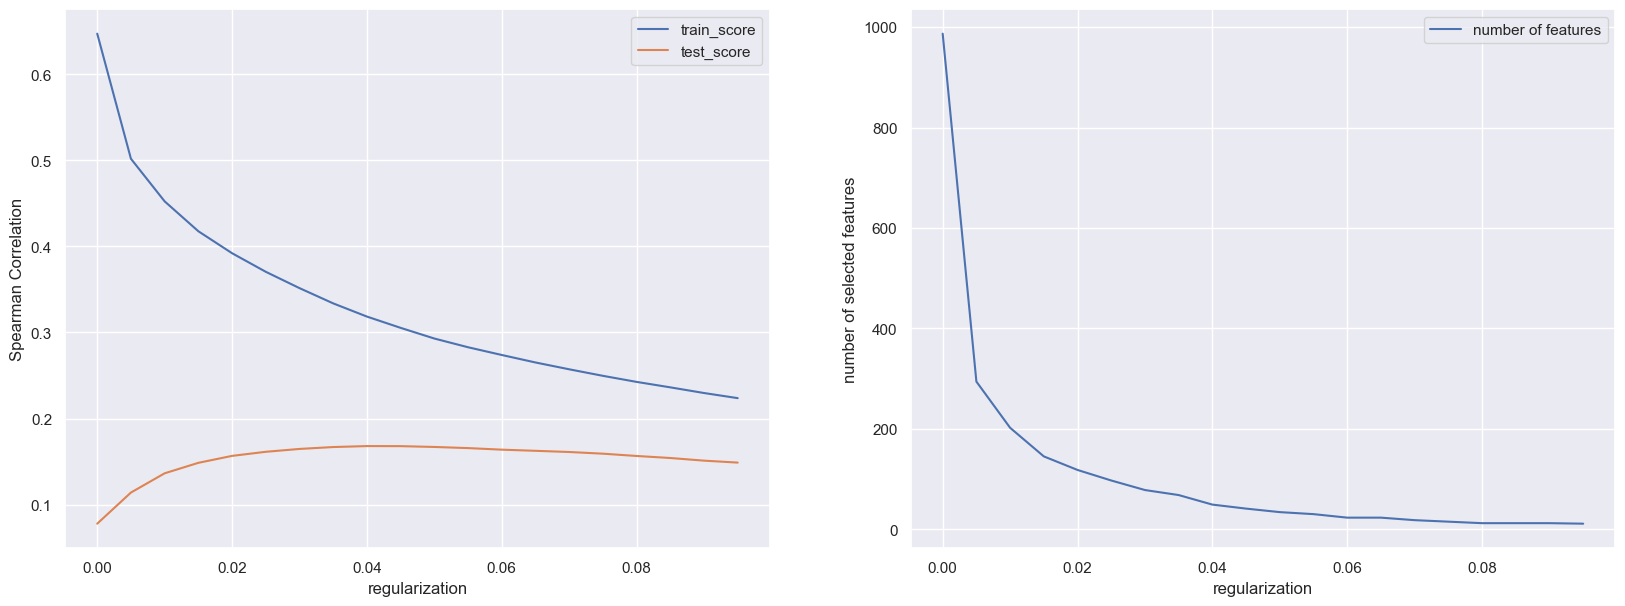

In [ ]:
model = Lasso#CustomLassoModel.CustomLassoModel

regularization, best_score, best_features = features_selection.lasso_feature_selection(X_train, y_train, model, stratify, number_of_states = 20)

benchmark['lasso']['DA lasso'] = {'test_score':best_score, 'features':best_features}

print("The best regularization = ", regularization)
print("The best_score = ", best_score)

print("The best_features = ", best_features)


### Sequential Feature Selection

In [ ]:
'''
best_score, best_features = features_selection.sequential_features_selection(X_train, np.array(y_train), models, stratify, number_of_states = 20, test_size = 0.3, max_features = 32)
for i in range(len(models)):
    model = models[i]
    benchmark[type(model).__name__ ]['DA sfs']  = {'test_score':best_score[i], 'features':best_features[i]}

    print("The best_score of " + type(model).__name__ + " = ", best_score[i])
    print("The best_features of " + type(model).__name__  +" = ", best_features[i])
'''

'\nbest_score, best_features = features_selection.sequential_features_selection(X_train, np.array(y_train), models, stratify, number_of_states = 20, test_size = 0.3, max_features = 32)\nfor i in range(len(models)):\n    model = models[i]\n    benchmark[type(model).__name__ ][\'DA sfs\']  = {\'test_score\':best_score[i], \'features\':best_features[i]}\n\n    print("The best_score of " + type(model).__name__ + " = ", best_score[i])\n    print("The best_features of " + type(model).__name__  +" = ", best_features[i])\n'

### Greedy Sequential Feature Selection

LinearRegression


100%|██████████| 989/989 [01:04<00:00, 15.36it/s]


The best_score of LinearRegression =  0.2514628092225308
The best_features of LinearRegression =  ['COUNTRY', 'DE_CONSUMPTION', 'FR_CONSUMPTION', 'DE_NET_EXPORT', 'DE_HYDRO', 'FR_NUCLEAR', 'COUNTRY DE_RESIDUAL_LOAD']


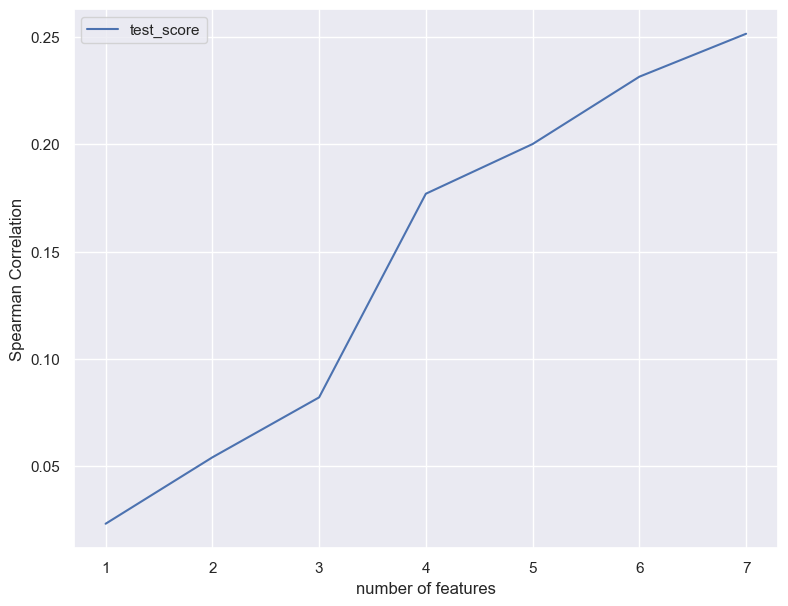

In [ ]:

best_score, best_features = features_selection.greedy_features_selection(X_train, np.array(y_train), models, stratify, threshold = 0.02, number_of_states = 20, test_size = 0.3, max_features = 32)
for i in range(len(models)):
    model = models[i]
    benchmark[type(model).__name__ ]['DA g_sfs']  = {'test_score':best_score[i], 'features':best_features[i]}

    print("The best_score of " + type(model).__name__ + " = ", best_score[i])
    print("The best_features of " + type(model).__name__  +" = ", best_features[i])


### Feature Selection Using Laplace Score

#### Laplace Tuning

100%|██████████| 9/9 [00:15<00:00,  1.73s/it]


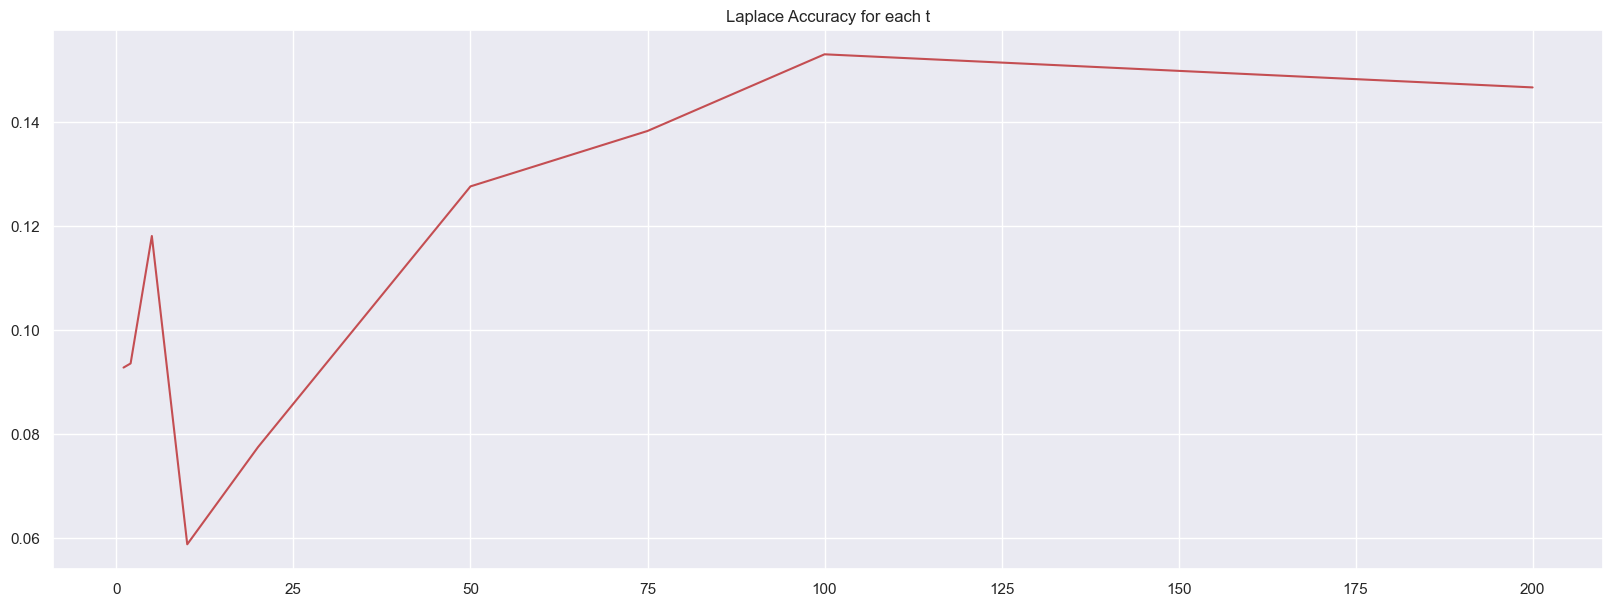

100

In [ ]:
laplace_var = features_selection.tune_laplace_features_selection(X_train, y_train, X_test, models[:1], stratify, var = [1, 2, 5, 10, 20 , 50, 75, 100, 200], number_of_states = 5, test_size = 0.3, max_features = 32)

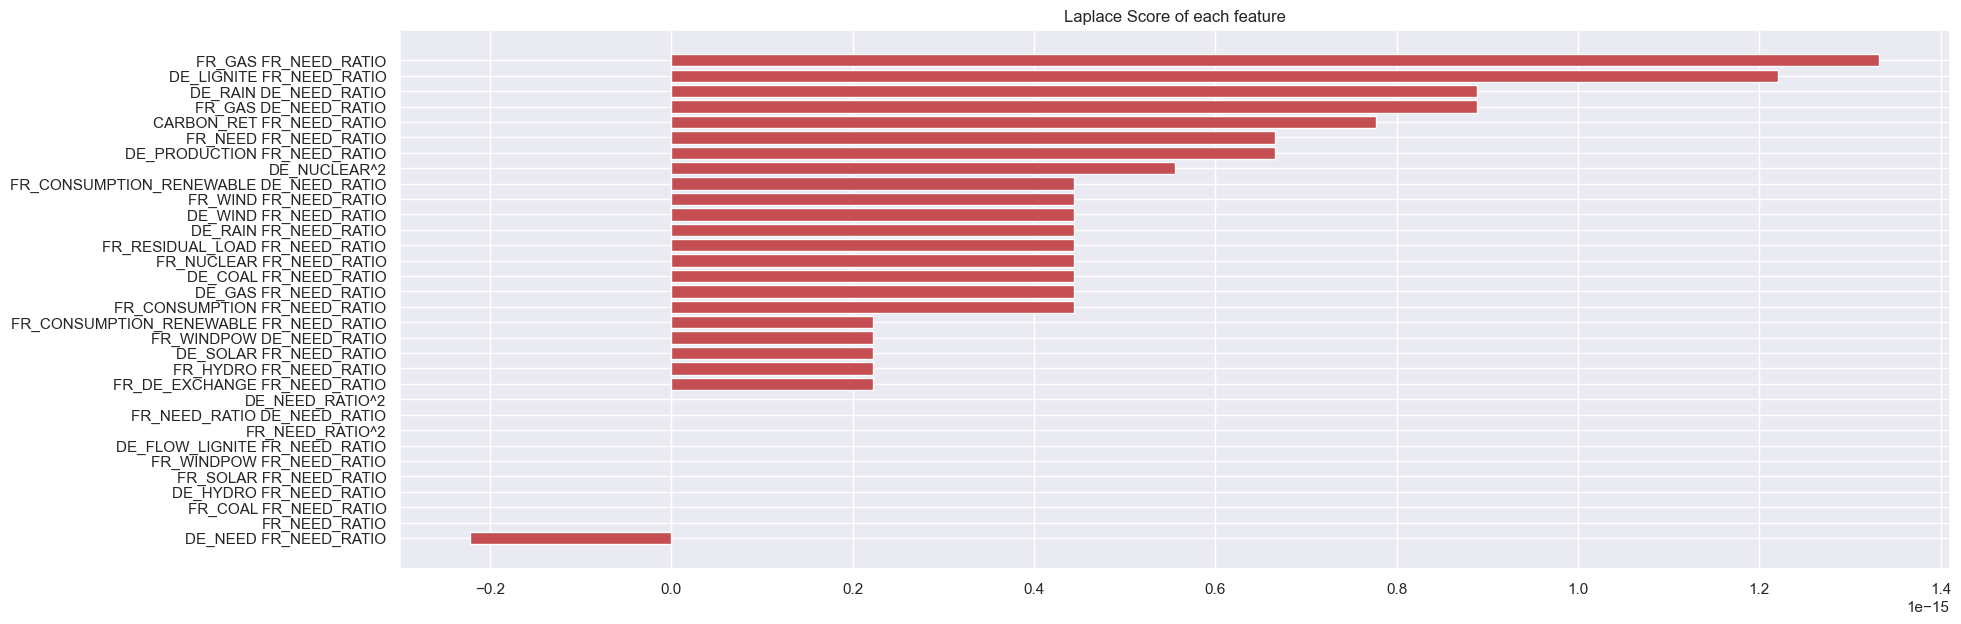

LinearRegression


100%|██████████| 30/30 [00:03<00:00,  8.81it/s]


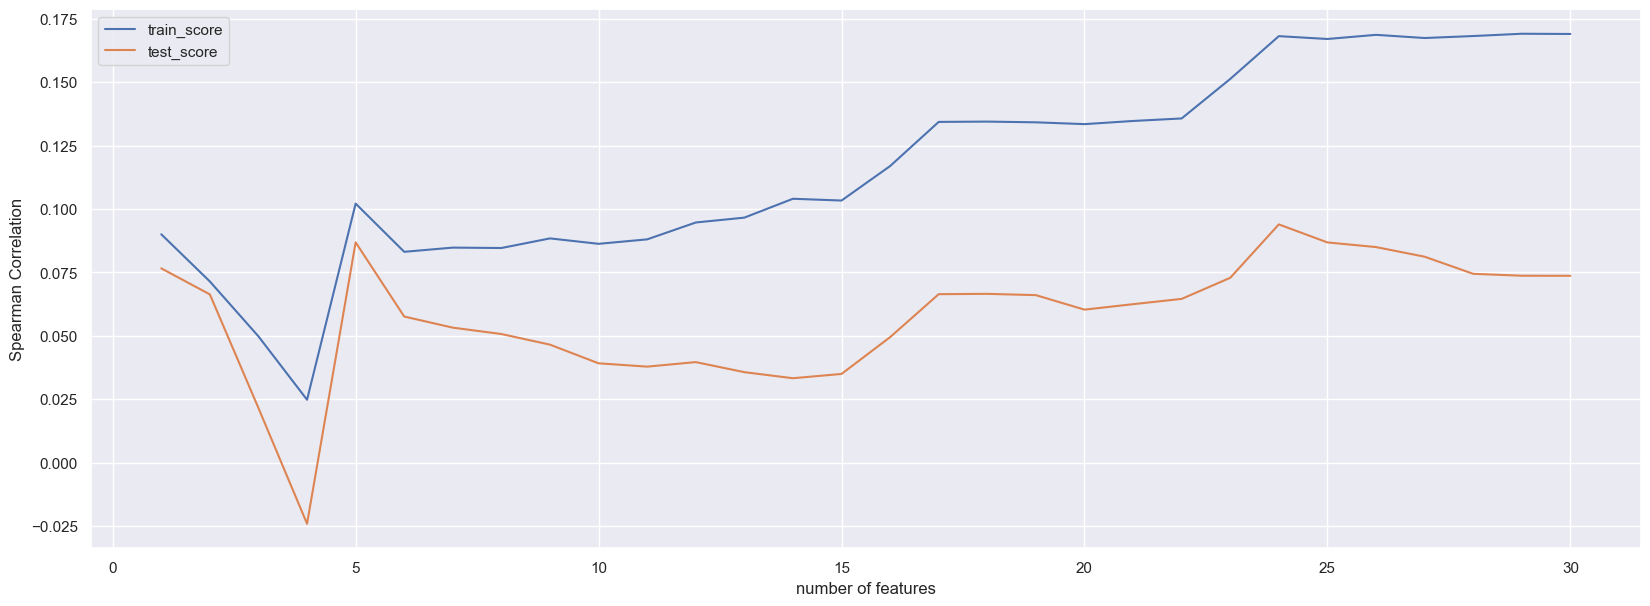

The best_score of LinearRegression =  0.09392046350088493
The best_features of LinearRegression =  ['DE_NEED FR_NEED_RATIO', 'FR_NEED_RATIO', 'FR_COAL FR_NEED_RATIO', 'DE_HYDRO FR_NEED_RATIO', 'FR_SOLAR FR_NEED_RATIO', 'FR_WINDPOW FR_NEED_RATIO', 'DE_FLOW_LIGNITE FR_NEED_RATIO', 'FR_NEED_RATIO^2', 'FR_NEED_RATIO DE_NEED_RATIO', 'DE_NEED_RATIO^2', 'FR_DE_EXCHANGE FR_NEED_RATIO', 'FR_HYDRO FR_NEED_RATIO', 'DE_SOLAR FR_NEED_RATIO', 'FR_WINDPOW DE_NEED_RATIO', 'FR_CONSUMPTION_RENEWABLE FR_NEED_RATIO', 'FR_CONSUMPTION FR_NEED_RATIO', 'DE_GAS FR_NEED_RATIO', 'DE_COAL FR_NEED_RATIO', 'FR_NUCLEAR FR_NEED_RATIO', 'FR_RESIDUAL_LOAD FR_NEED_RATIO', 'DE_RAIN FR_NEED_RATIO', 'DE_WIND FR_NEED_RATIO', 'FR_WIND FR_NEED_RATIO', 'FR_CONSUMPTION_RENEWABLE DE_NEED_RATIO', 'DE_NUCLEAR^2', 'DE_PRODUCTION FR_NEED_RATIO']


In [ ]:
best_score, best_features = features_selection.laplace_features_selection(X_train, y_train, X_test, models, stratify, var = laplace_var, number_of_states = 20)

for i in range(len(models)):
    model = models[i]
    benchmark[type(model).__name__]['DA Laplace'] = {'test_score':best_score[i], 'features':best_features[i]}
    print("The best_score of " + type(model).__name__ + " = ", best_score[i])
    print("The best_features of " + type(model).__name__  +" = ", best_features[i])

## Features Selection Using Information Theory:

### Minimum Redundancy Maximum Relevance (MRMR)

The score of each new feature :
$$J_{MRMR}(X_k) = I(X_k,Y) - \frac{1}{|S|}\sum_{X_j \in s}I(X_k,x_j)$$

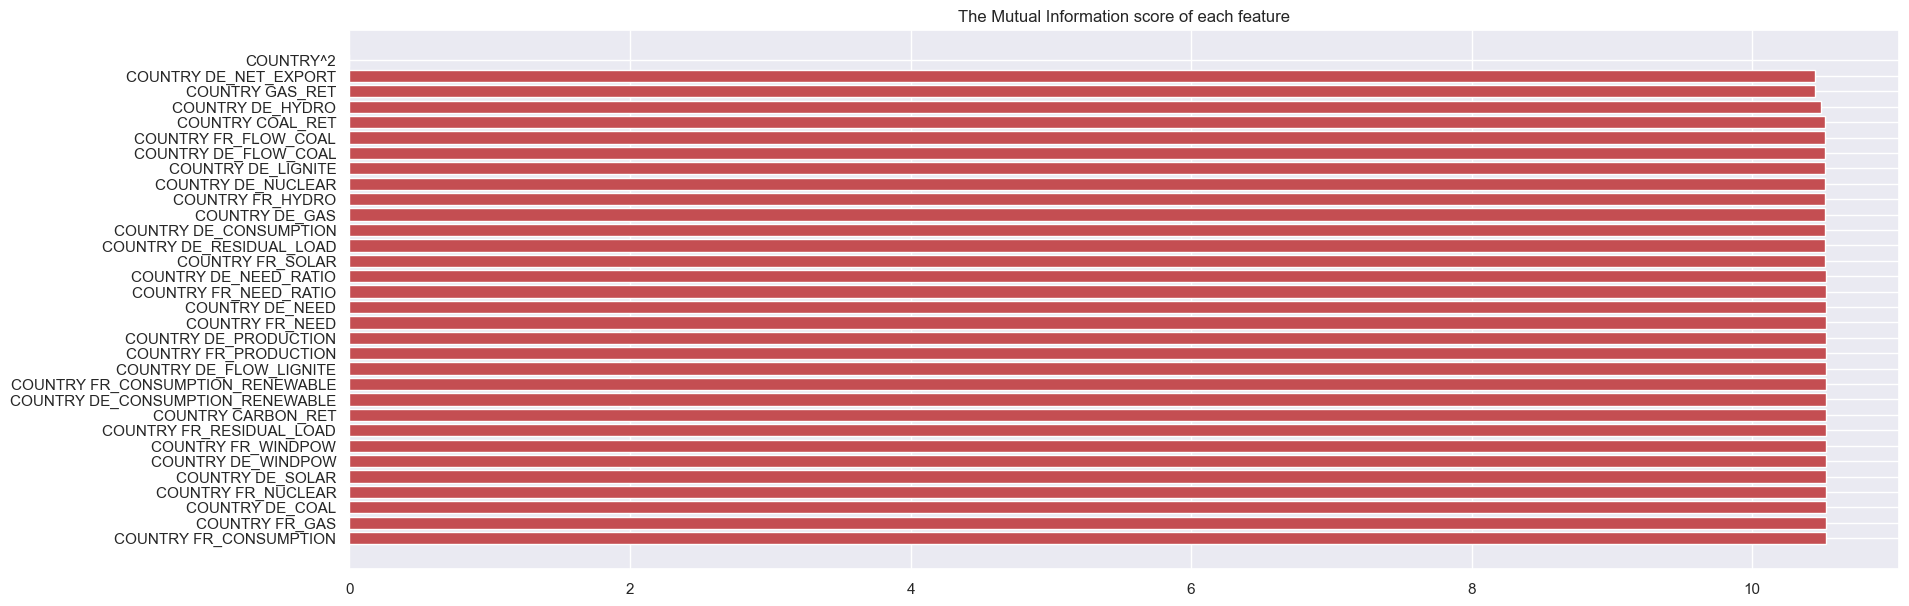

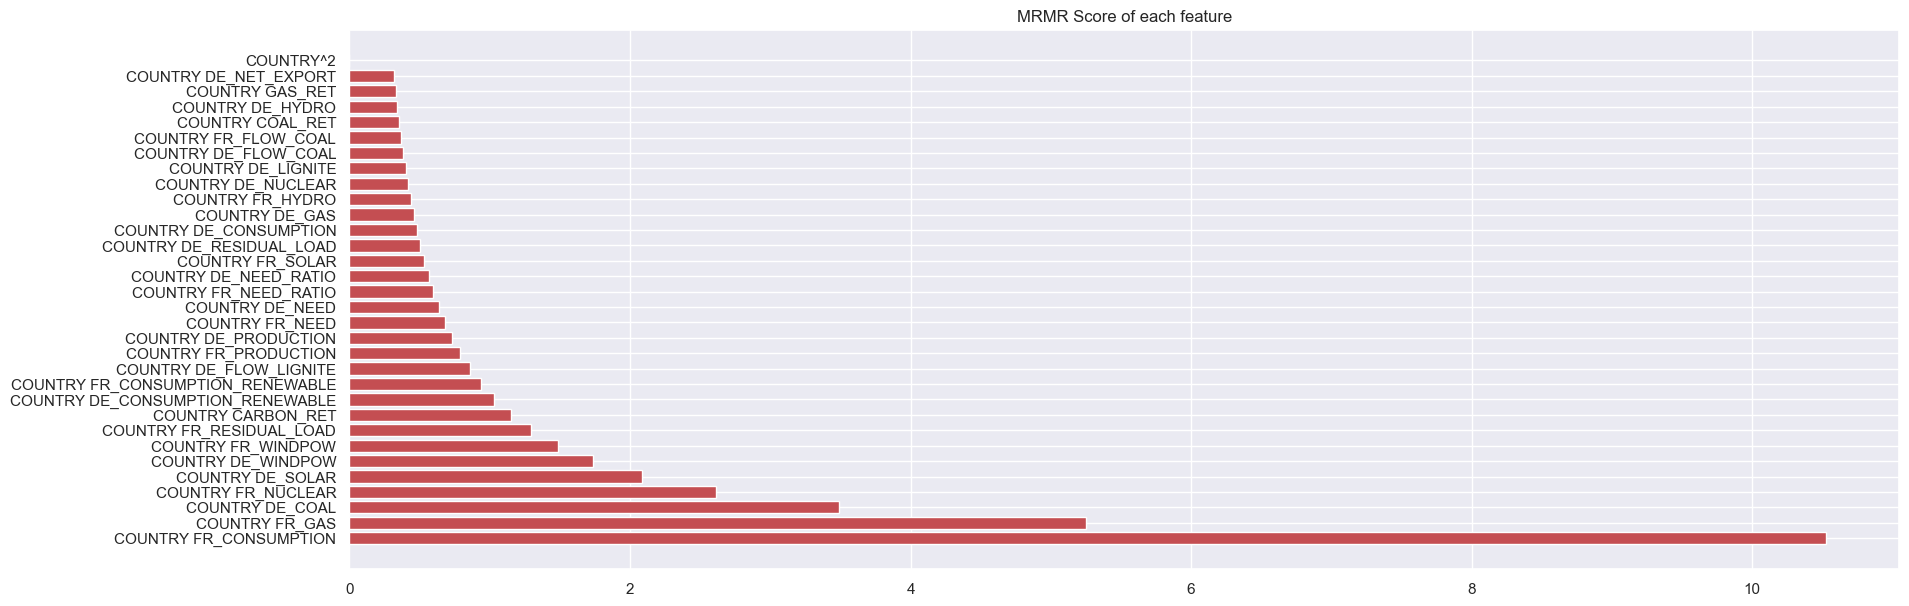

LinearRegression


100%|██████████| 30/30 [00:03<00:00,  8.54it/s]


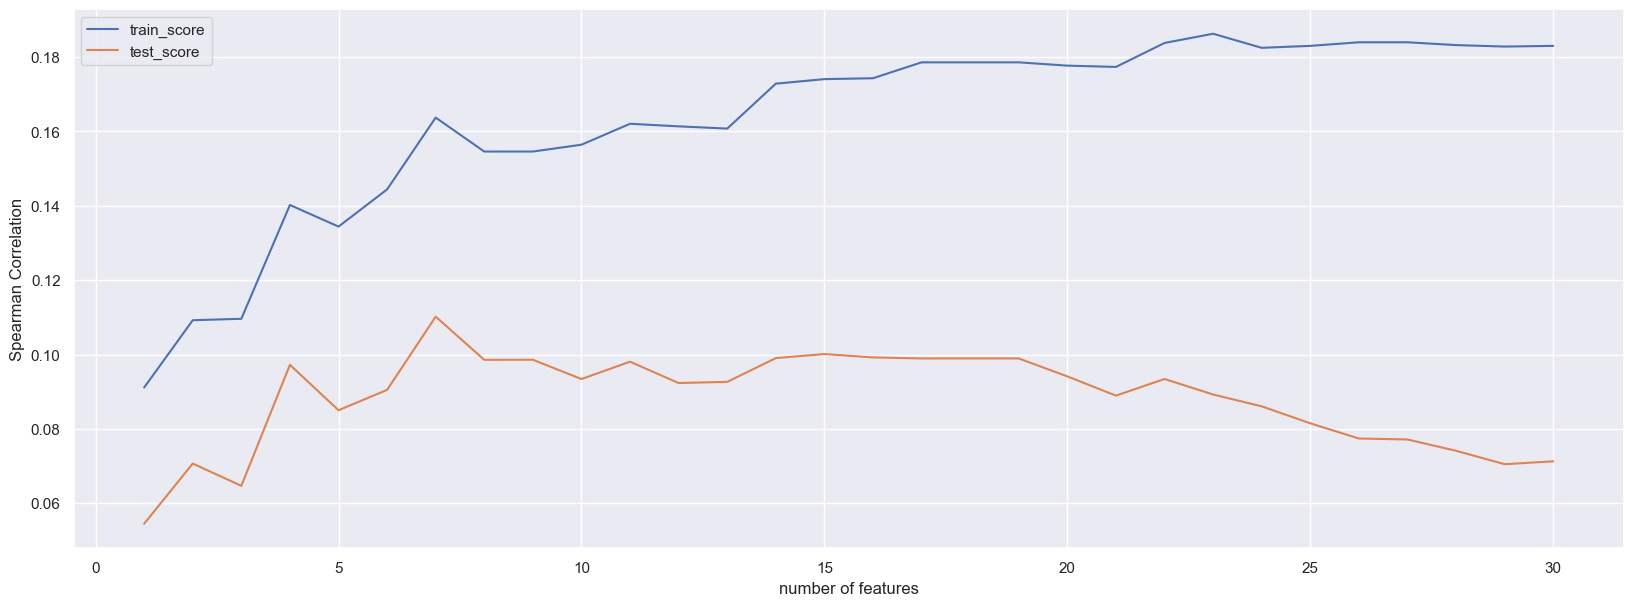

The best_score of LinearRegression =  0.11018833767795204
The best_features of LinearRegression =  ['COUNTRY FR_CONSUMPTION', 'COUNTRY FR_GAS', 'COUNTRY DE_COAL', 'COUNTRY FR_NUCLEAR', 'COUNTRY DE_SOLAR', 'COUNTRY DE_WINDPOW', 'COUNTRY FR_WINDPOW', 'COUNTRY FR_RESIDUAL_LOAD', 'COUNTRY CARBON_RET']


In [ ]:
best_score, best_features = features_selection.MRMR_features_selection(X_train, y_train, X_test, models, stratify,  number_of_states = 20)

for i in range(len(models)):
    model = models[i]
    benchmark[type(model).__name__]['DA MRMR'] = {'test_score':best_score[i], 'features':best_features[i]}
    print("The best_score of " + type(model).__name__ + " = ", best_score[i])
    print("The best_features of " + type(model).__name__  +" = ", best_features[i])

In [ ]:
results = pd.DataFrame(columns=['model','DA w/o FS', 'DA lasso', 'DA Laplace', 'DA MRMR', 'DA sfs', 'DA g_sfs'])
cols = ['DA w/o FS', 'DA lasso', 'DA Laplace', 'DA MRMR', 'DA sfs', 'DA g_sfs']
for i in benchmark.keys():
    res = [i]
    for z in cols:
        if(z in benchmark[i]):
            res.append(benchmark[i][z]['test_score'])
        else:
            res.append(np.nan)
    results.loc[len(results)] = res

In [ ]:
print(tabulate(results, headers='keys', tablefmt='fancy_grid'))

╒════╤══════════════════╤═════════════╤════════════╤══════════════╤════════════╤══════════╤════════════╕
│    │ model            │   DA w/o FS │   DA lasso │   DA Laplace │    DA MRMR │   DA sfs │   DA g_sfs │
╞════╪══════════════════╪═════════════╪════════════╪══════════════╪════════════╪══════════╪════════════╡
│  0 │ lasso            │ nan         │   0.167953 │  nan         │ nan        │      nan │ nan        │
├────┼──────────────────┼─────────────┼────────────┼──────────────┼────────────┼──────────┼────────────┤
│  1 │ LinearRegression │   0.0616608 │ nan        │    0.0939205 │   0.110188 │      nan │   0.251463 │
╘════╧══════════════════╧═════════════╧════════════╧══════════════╧════════════╧══════════╧════════════╛


In [ ]:
freq = dict()
for i in benchmark.keys():
    for j in benchmark[i].keys():
        
        if(j[:2] != 'DA'):
            continue
        if(j == 'DA w/o FS'):
            continue
        
        if(i not in freq):
            freq[i] = dict()
        if(j not in freq[i]):
            freq[i][j] = 0
        freq[i][j] += (len(benchmark[i][j]['features'])/X_train.shape[1])*100


In [ ]:
freq_data = pd.DataFrame(freq).T
freq_data

,DA lasso,DA g_sfs,DA Laplace,DA MRMR
lasso,4.954499,NaN,NaN,NaN
LinearRegression,NaN,0.707786,2.628918,0.91001
